In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import os
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import xgboost as xgb
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from sklearn.metrics import (precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [86]:
aisles = pd.read_csv('C:/Users/Veena Chintala/Desktop/326/FinalProject/aisles.csv')
departments = pd.read_csv('C:/Users/Veena Chintala/Desktop/326/FinalProject/departments.csv')
priors = pd.read_csv('C:/Users/Veena Chintala/Desktop/326/FinalProject/order_products__prior.csv')
orders = pd.read_csv('C:/Users/Veena Chintala/Desktop/326/FinalProject/orders.csv')
products = pd.read_csv('C:/Users/Veena Chintala/Desktop/326/FinalProject/products.csv')
#sample_submission = pd.read_csv('C:/Users/Veena Chintala/Desktop/326/FinalProject/sample_submission.csv')
train= pd.read_csv('C:/Users/Veena Chintala/Desktop/326/FinalProject/order_products__train.csv')

In [57]:
priors.isnull().sum(), orders.isnull().sum(), train.isnull().sum()

(order_id             0
 product_id           0
 add_to_cart_order    0
 reordered            0
 dtype: int64, order_id                   0
 user_id                    0
 eval_set                   0
 order_number               0
 order_dow                  0
 order_hour_of_day          0
 days_since_prior_order    28
 dtype: int64, order_id             0
 product_id           0
 add_to_cart_order    0
 reordered            0
 dtype: int64)

In [84]:
train.head()

,order_id,product_id,add_to_cart_order,reordered


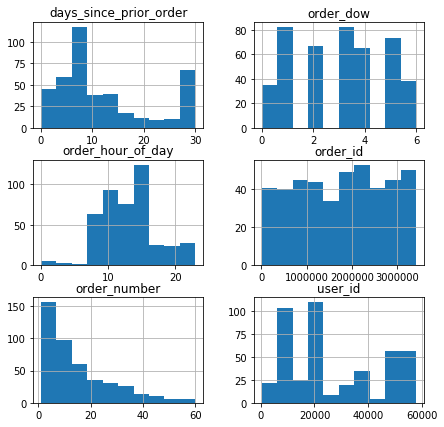

In [59]:
orders.hist(figsize = (7,7));

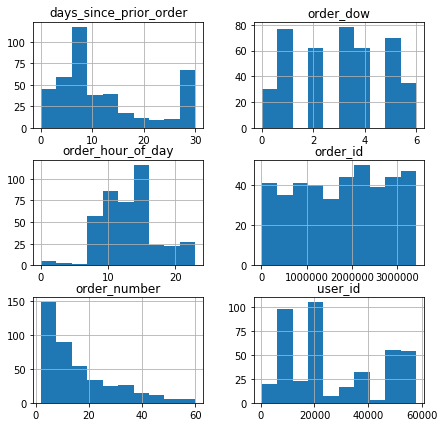

In [63]:
orders[orders.days_since_prior_order.notnull()].hist(figsize = (7,7));

In [46]:
priors.shape, priors.duplicated().sum()

((674331, 4), 0)

In [48]:
train.shape, train.duplicated().sum()

((21493, 4), 0)

In [47]:
orders.shape, orders.duplicated().sum()

((69994, 7), 0)

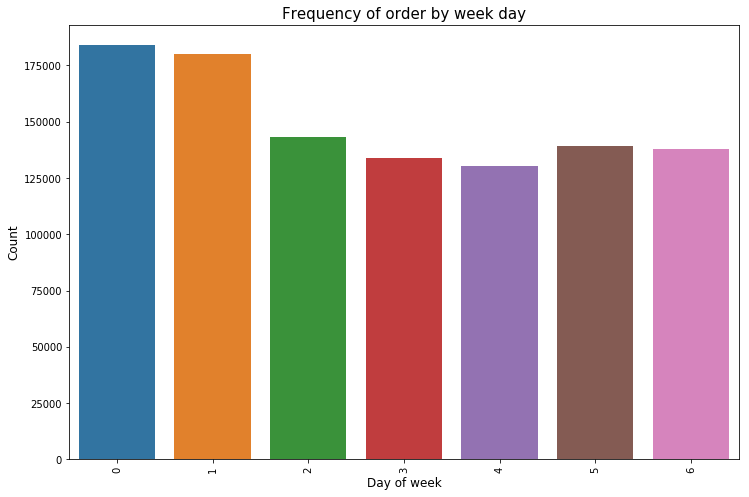

In [16]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

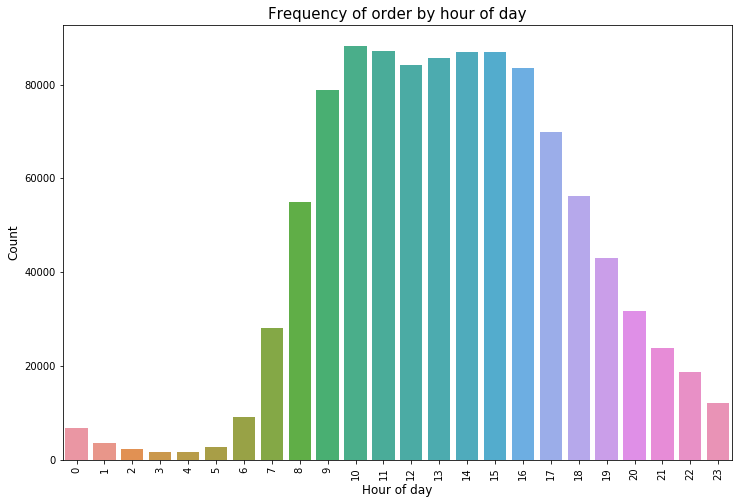

In [17]:
#The days of the week have not beed named, but for the sake of this project, we assume that 0 is Saturday and 1 is Sunday. 
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

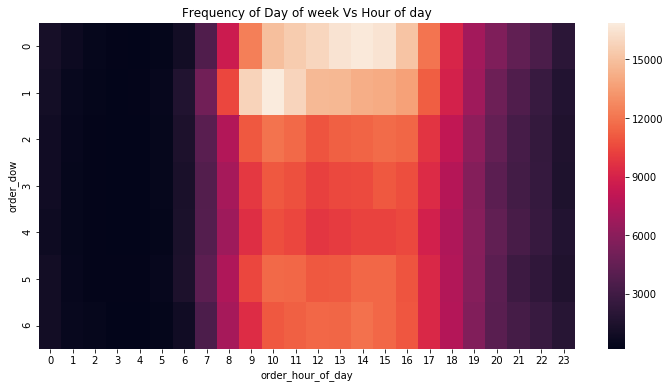

In [18]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

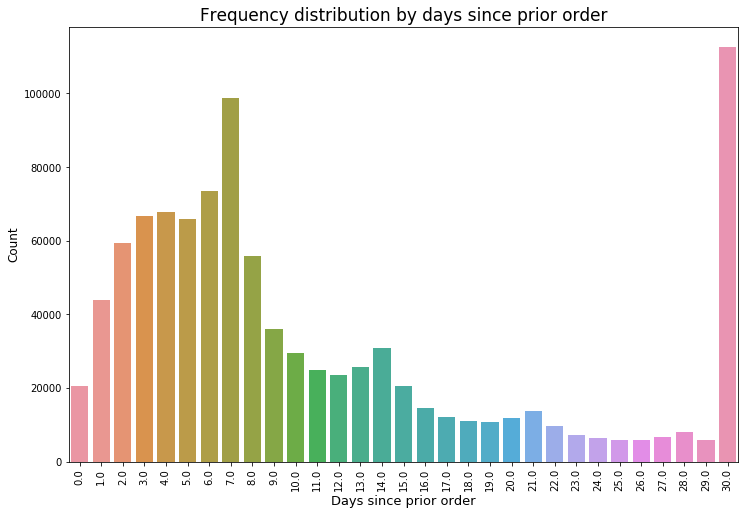

In [20]:
#It looks like Saturday evening and Sunday mornings are when people order the most
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=13)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=17)
plt.show()

In [87]:
# % of re-orders in the Prior Data Set 
priors.reordered.sum() / priors.shape[0]

0.5896974667922161

In [24]:
# % of re-orders in the Train Data Set 
train.reordered.sum() / train.shape[0]

0.5985944127509629

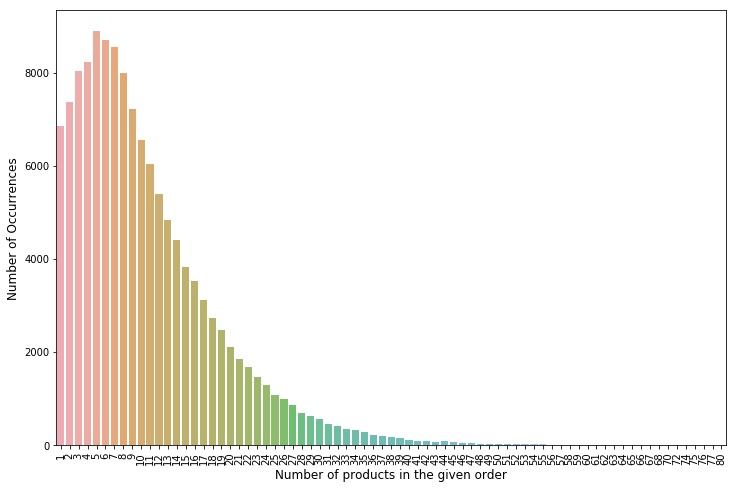

In [88]:
grouped_df = train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [89]:
order_products_prior_df = pd.merge(priors, products, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [90]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs.head()

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584


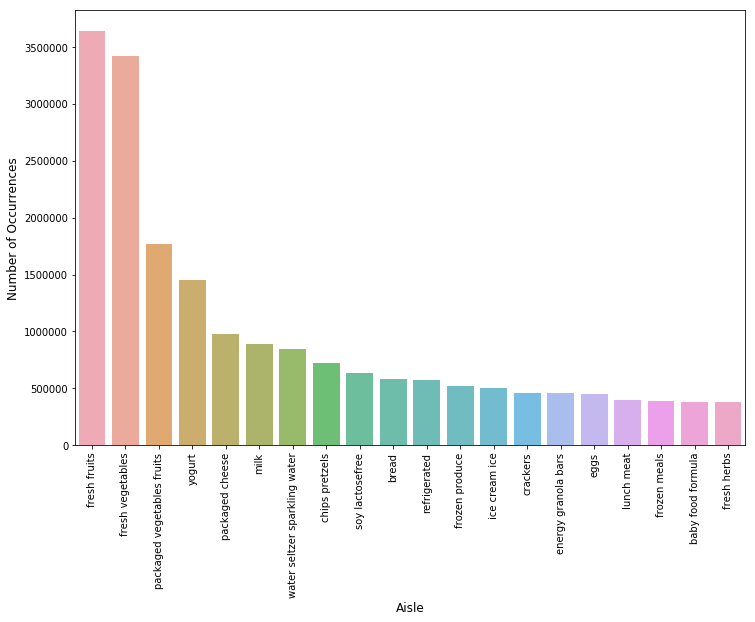

In [91]:
#It looks like people ordered a lot of Organic products, and a lot of fruits!
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

# Clealry, produce, and dairy are the largest departments
### We are interested in the patterns of re orders, so here we explore the correlation b/w adding an item to the car, with the order ratio.
### Not surprisingly, it looks like people ended up purchasing the products that they FIRST added to their cart, compared to those that were added later.

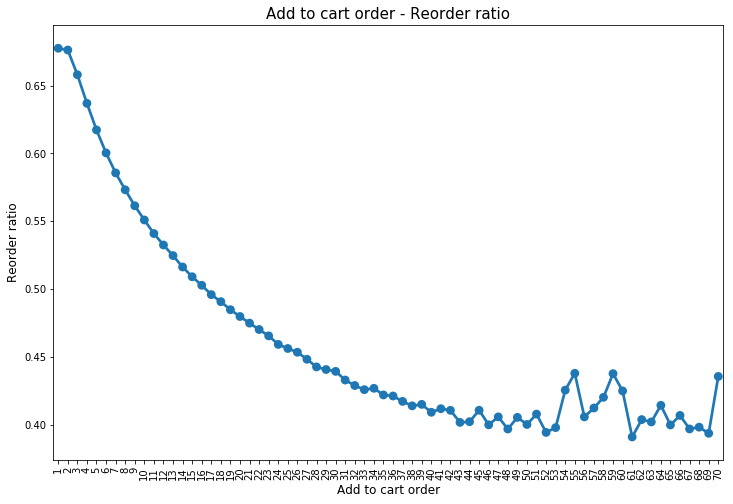

In [92]:
#take a look at this gragh
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

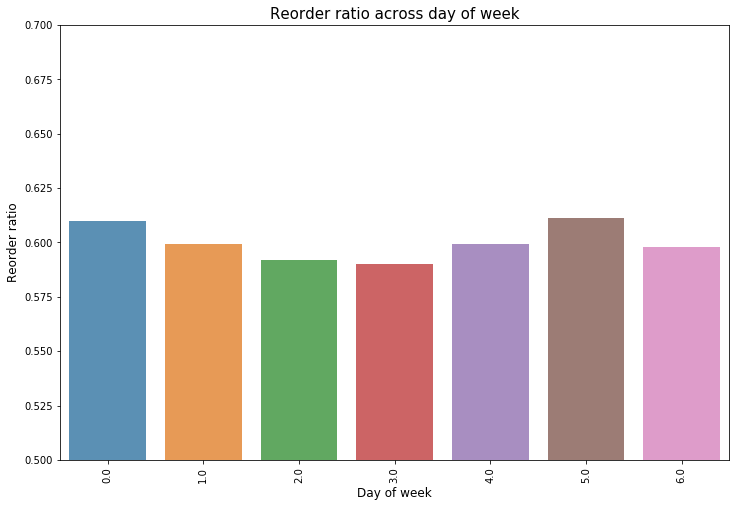

In [93]:
order_products_train_df = pd.merge(train, orders, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

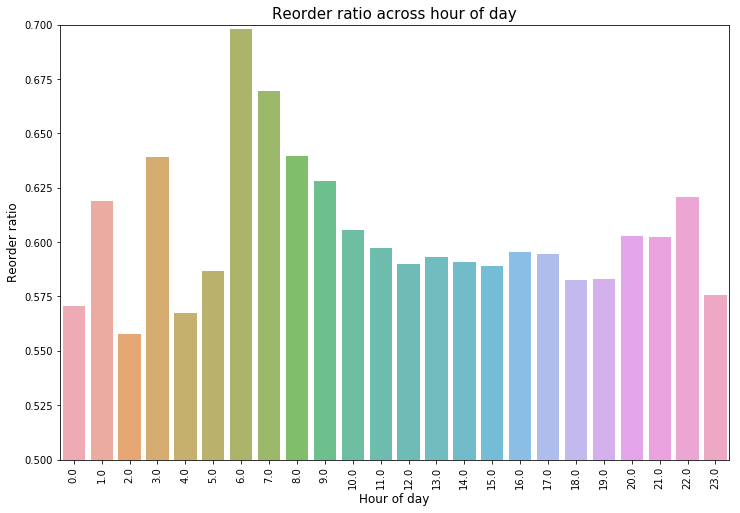

In [94]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

In [95]:
# Reduce the dataset to produce a smaller number of users
fracTrain = 0.05
fracTest = 0.1

# Total users,order_id in train set. This include both the actual training set and the holdout set
sampleOrdersTrain = orders[orders["eval_set"]=="train"][["user_id","order_id"]].drop_duplicates().sample(frac=fracTrain).reset_index(drop=True)
sampleOrdersTest = orders[orders["eval_set"]=="test"][["user_id","order_id"]].drop_duplicates().sample(frac=fracTest).reset_index(drop=True)
sampleOrders = pd.concat([sampleOrdersTrain, sampleOrdersTest], ignore_index=True)

orders = orders[orders["user_id"].isin(sampleOrders["user_id"])].reset_index(drop=True)
train = train[train["order_id"].isin(orders["order_id"])].reset_index(drop=True)
priors = priors[priors["order_id"].isin(orders["order_id"])].reset_index(drop=True)

In [96]:
print('Orders: ', len(orders))
print('Priors: ', len(priors))
print('Train: ', len(train))
print('sampleOrders: ', len(sampleOrders))

Orders:  71385
Priors:  680858
Train:  21170
sampleOrders:  4305


In [97]:
sizes = orders["eval_set"].value_counts()
sizes

prior    67080
test      2300
train     2005
Name: eval_set, dtype: int64

In [98]:
pr = priors.copy()
print(len(pr))
pr.head()

680858


,order_id,product_id,add_to_cart_order,reordered
0,43,20915,1,0
1,43,21949,2,0
2,43,8817,3,0
3,43,37867,4,1
4,43,12850,5,0


# User Behavior Features

## 1. Average Days between orders
## 2. Average day of week
## 3. Average hour of the day

In [99]:
usr = orders.groupby('user_id')['days_since_prior_order'].mean().to_frame('avg_days_between_orders').reset_index()
dow = orders.groupby('user_id')['order_dow'].mean().to_frame('avg_order_dow').reset_index()
hod = orders.groupby('user_id')['order_hour_of_day'].mean().to_frame('avg_order_hod').reset_index()
hod['avg_order_hod'] = hod['avg_order_hod']/4
usr = usr.merge(dow, on='user_id')
usr = usr.merge(hod, on='user_id')
del dow
del hod
usr.head()


,user_id,avg_days_between_orders,avg_order_dow,avg_order_hod
0,4,17.000000,4.500000,3.125000
1,57,8.071429,3.933333,2.666667
2,58,9.133333,2.500000,3.125000
3,77,14.666667,1.461538,3.211538
4,82,11.263158,2.350000,2.975000


In [100]:
# 3. Average order size
# 4. Average Number of reorder/ cart
# for avergae caculation look at section (contd.. user feature)

order_sizes = priors.groupby(['order_id']).size().to_frame('size_order').reset_index()
order_sizes['num_reordered'] = priors['reordered'].groupby(priors['order_id']).sum().reset_index()['reordered']
order_sizes.head()

,order_id,size_order,num_reordered
0,43,7,2
1,74,11,11
2,102,10,3
3,210,17,10
4,248,14,8


In [101]:
orders['Weekend?'] = [1 if x in [0,1] else 0 for x in orders['order_dow']]
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?
0,3343014,4,prior,1,6,11,NaN,0
1,2030307,4,prior,2,4,11,19.0,0
2,691089,4,prior,3,4,15,21.0,0
3,94891,4,prior,4,5,13,15.0,0
4,2557754,4,prior,5,5,13,0.0,0


# Now let's start lookin into user space
## Number of times user ordered product
## Frequnecy: Number of times order product/ total prior orders

In [102]:
# Create a merged table with user_id, product_id and times it has been ordered in all previous orders

# Crate dataframe for prpduct_id and User ID
t1 = priors[["order_id", "product_id"]] # get order id, product id from prior data
t2 = orders[orders["eval_set"]=="prior"][["order_id","user_id"]]# get order id, user id from order data
df = pd.merge(t1, t2, on="order_id").drop("order_id", 1) # Combine two data and drop order_id
counts = pd.DataFrame({"Times_Ordered": df.groupby(by=["user_id","product_id"]).size()}).reset_index()
counts.head()

,user_id,product_id,Times_Ordered
0,4,1200,1
1,4,2707,1
2,4,7160,1
3,4,7350,1
4,4,11865,1


In [103]:
# Select only users in train set
# Do the same for the training set, showing all the single purchases
t1 = train[["order_id", "product_id"]]# get order id, product id from train data
t2 = orders[orders["eval_set"]=="train"][["order_id","user_id"]] # get order id, product id from order data
df = pd.merge(t1, t2, on="order_id").drop("order_id", 1)# Combine two data and drop order_id
df.head()
t2.head()

,order_id,user_id
69,859654,82
78,1227088,95
85,1997693,109
162,2560500,140
215,3294802,157


In [109]:
# Aggregate data by orders.
# Find out which products have been repurchased
trainUsers = orders[orders["eval_set"]=="train"]["user_id"] # Get only userid from orders table
trainCounts  = counts[counts["user_id"].isin(trainUsers)] # Get prior order details(times ordered,product_id,user_id) for coorsponsing users

In [105]:
timesOrd_per_UsrXProd = pd.merge(trainCounts, df, on=["user_id","product_id"], how='left', indicator="Purchased") 
#Here indicator will specify whether product is mentioned in both train  and prior order

timesOrd_per_UsrXProd["Repurchased"] = np.where(timesOrd_per_UsrXProd.Purchased == "both", 1, 0)
# When it is mentioned in both it is categoriesed as 1, else it is 0

timesOrd_per_UsrXProd.drop("Purchased", 1, inplace=True)# we used purchased column to tage repurchased column and now delete

print(timesOrd_per_UsrXProd.shape)

(130186, 4)


In [110]:
# Add columns with historical frequency (number of times product has been bought divided by number of orders from user)
ordersPerUser = orders[orders["eval_set"]=="train"][["user_id","order_number"]]
ordersPerUser["numberPriorOrder"] = ordersPerUser["order_number"]-1 # Number of prior order=total orders -1
ordersPerUser.drop("order_number", 1, inplace=True)

timesOrd_per_UsrXProd = pd.merge(timesOrd_per_UsrXProd, ordersPerUser, how="left", on="user_id")

In [111]:
timesOrd_per_UsrXProd["frequency"] = timesOrd_per_UsrXProd["Times_Ordered"]/timesOrd_per_UsrXProd["numberPriorOrder"]
timesOrd_per_UsrXProd.head()

,user_id,product_id,Times_Ordered,Repurchased,numberPriorOrders_x,numberPriorOrders_y,numberPriorOrder,frequency
0,82,196,9,0,19,19,19,0.473684
1,82,6184,4,0,19,19,19,0.210526
2,82,9076,1,0,19,19,19,0.052632
3,82,10441,4,0,19,19,19,0.210526
4,82,11759,4,1,19,19,19,0.210526


In [112]:
# The order number in the train/test sets corresponds to the total number of orders in the prior set
ordersPerUser = orders[orders["eval_set"].isin(["train","test"])][["user_id","order_number"]]
ordersPerUser.rename(columns={"order_number":"tot_orders"}, inplace=True)
ordersPerUser.head()

,user_id,tot_orders
5,4,6
20,57,15
36,58,16
49,77,13
69,82,20


In [113]:
#Combine Priors With Order Data
priors = pd.merge(priors, orders, on='order_id')
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?
0,43,20915,1,0,39630,prior,14,5,17,4.0,0
1,43,21949,2,0,39630,prior,14,5,17,4.0,0
2,43,8817,3,0,39630,prior,14,5,17,4.0,0
3,43,37867,4,1,39630,prior,14,5,17,4.0,0
4,43,12850,5,0,39630,prior,14,5,17,4.0,0


# Product Features:
## 1.Total Order of product.
## 2.product reorder ratio.
## 3.product reorder probability

In [114]:
prior_sort = priors.sort_values(['user_id', 'order_number', 'product_id'], ascending=True) # Ascending sort of user id, order number, product id
prior_sort = prior_sort.assign(product_time = prior_sort.groupby(['user_id', 'product_id']).cumcount()+1) # cumulatove sum of product

In [116]:
# For calculating reorder probability

sub1 = prior_sort[prior_sort['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
#Count of all products which are order frist time (i.e. count of all records where reorder = 0)

sub2 = prior_sort[prior_sort['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')#Count of all products which are order Second time

In [117]:
# Calculate total order of one product and Reorder of that product

sub1['prod_orders'] = prior_sort.groupby('product_id')['product_id'].size() # Add Total order to data frame
sub1['prod_reorders'] = prior_sort.groupby('product_id')['reordered'].sum() # Add Total reorders to data frame
sub2   = sub2.reset_index().merge(sub1.reset_index())
# So now we have dataframe with product id, the first order count, second order count, count total order and sumof total number of reorders.
sub2.head()

,product_id,prod_second_orders,prod_first_orders,prod_orders,prod_reorders
0,1,5,21,33,12
1,4,4,5,14,9
2,7,1,1,3,2
3,8,1,3,4,1
4,9,2,2,8,6


In [118]:
# calculating reorder probability and ratio for the product

sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders'] /sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]
prd.head()

,product_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,1,33,0.238095,0.363636
1,4,14,0.800000,0.642857
2,7,3,1.000000,0.666667
3,8,4,0.333333,0.250000
4,9,8,1.000000,0.750000


In [119]:
#Let's combine all product related features to the product dataframe
products= pd.merge(products,prd,on='product_id')
products.head()

,product_id,product_name,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,1,Chocolate Sandwich Cookies,61,19,33,0.238095,0.363636
1,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,14,0.800000,0.642857
2,7,Pure Coconut Water With Orange,98,7,3,1.000000,0.666667
3,8,Cut Russet Potatoes Steam N' Mash,116,1,4,0.333333,0.250000
4,9,Light Strawberry Blueberry Yogurt,120,16,8,1.000000,0.750000


In [120]:
df = pd.merge(priors, order_sizes, on='order_id')
df['cart_priority'] = 1 - df['add_to_cart_order']/(df['size_order']+1)
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,size_order,num_reordered,cart_priority
0,43,20915,1,0,39630,prior,14,5,17,4.0,0,7,2,0.875
1,43,21949,2,0,39630,prior,14,5,17,4.0,0,7,2,0.750
2,43,8817,3,0,39630,prior,14,5,17,4.0,0,7,2,0.625
3,43,37867,4,1,39630,prior,14,5,17,4.0,0,7,2,0.500
4,43,12850,5,0,39630,prior,14,5,17,4.0,0,7,2,0.375


In [121]:
#contd.. user feature
avg_sizes = df[['user_id','size_order','num_reordered']].groupby(['user_id']).mean().reset_index()
avg_sizes.rename(columns={"size_order":"avg_order_size", "num_reordered":"avg_n_reordered"}, inplace=True)
avg_sizes.head()

,user_id,avg_order_size,avg_n_reordered
0,4,4.555556,0.388889
1,57,5.972222,3.625000
2,58,7.804124,2.597938
3,77,18.408867,7.645320
4,82,8.083969,6.412214


In [122]:
timesOrdered = df.groupby(['user_id','product_id']).agg({'count','mean'})['cart_priority'].reset_index()
timesOrdered.rename(columns={"mean":"avg_cart_priority", "count":"times_ord"}, inplace=True)
timesOrdered = pd.merge(timesOrdered, avg_sizes, on='user_id')
df.drop(['cart_priority'], 1, inplace=True)

del avg_sizes

timesOrdered.head()

,user_id,product_id,times_ord,avg_cart_priority,avg_order_size,avg_n_reordered
0,4,1200,1,0.875000,4.555556,0.388889
1,4,2707,1,0.200000,4.555556,0.388889
2,4,7160,1,0.333333,4.555556,0.388889
3,4,7350,1,0.600000,4.555556,0.388889
4,4,11865,1,0.375000,4.555556,0.388889


In [123]:
df = pd.merge(df, timesOrdered, on=["user_id","product_id"])
df = pd.merge(df, usr, on=['user_id'])
df = pd.merge(df, ordersPerUser, on=["user_id"])
df = pd.merge(df, products.drop('product_name',1), on="product_id")
df = df.drop('eval_set', 1)

del timesOrdered, usr, ordersPerUser

In [124]:
df["days_since_prior_order"].fillna(0,inplace=True)
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,...,avg_n_reordered,avg_days_between_orders,avg_order_dow,avg_order_hod,tot_orders,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,43,20915,1,0,39630,14,5,17,4.0,0,...,1.550000,4.285714,2.866667,3.666667,15,21,16,10,0.2,0.5
1,2852444,20915,11,0,28193,11,1,17,6.0,1,...,5.485437,8.166667,2.692308,3.500000,13,21,16,10,0.2,0.5
2,1094405,20915,9,0,26898,25,2,17,5.0,0,...,9.196947,7.500000,3.571429,2.959184,49,21,16,10,0.2,0.5
3,1879226,20915,14,0,56765,5,4,11,24.0,0,...,4.200000,19.000000,2.888889,2.583333,9,21,16,10,0.2,0.5
4,256074,20915,4,1,35867,6,4,12,7.0,0,...,10.869919,15.857143,3.625000,3.312500,8,21,16,10,0.2,0.5


# Features for Train and Test Sets

In [125]:
featuresTrain = pd.merge(df, orders[orders["eval_set"]=="train"][["user_id"]],on="user_id",how="inner")

In [126]:
# Append target column
trainProducts = pd.merge(train, orders, on="order_id")[["user_id","product_id"]]
featuresTrain = pd.merge(featuresTrain, trainProducts, how="left", indicator="repurchased")
featuresTrain["repurchased"] = np.where(featuresTrain.repurchased == "both", 1, 0)
featuresTest = pd.merge(df, orders[orders["eval_set"]=="test"][["user_id"]],on="user_id",how="inner")

In [127]:
assert(featuresTrain.shape[0]+featuresTest.shape[0]==df.shape[0])
print(featuresTrain.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'Weekend?', 'size_order', 'num_reordered',
       'times_ord', 'avg_cart_priority', 'avg_order_size', 'avg_n_reordered',
       'avg_days_between_orders', 'avg_order_dow', 'avg_order_hod',
       'tot_orders', 'aisle_id', 'department_id', 'prod_orders',
       'prod_reorder_probability', 'prod_reorder_ratio', 'repurchased'],
      dtype='object')


In [128]:
featuresTrain.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,...,avg_days_between_orders,avg_order_dow,avg_order_hod,tot_orders,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_ratio,repurchased
0,43,20915,1,0,39630,14,5,17,4.0,0,...,4.285714,2.866667,3.666667,15,21,16,10,0.200000,0.500000,0
1,43,21949,2,0,39630,14,5,17,4.0,0,...,4.285714,2.866667,3.666667,15,21,16,29,0.538462,0.551724,0
2,43,8817,3,0,39630,14,5,17,4.0,0,...,4.285714,2.866667,3.666667,15,60,17,4,0.333333,0.250000,0
3,43,37867,4,1,39630,14,5,17,4.0,0,...,4.285714,2.866667,3.666667,15,61,19,19,0.300000,0.473684,0
4,1176352,37867,5,0,39630,7,3,16,2.0,0,...,4.285714,2.866667,3.666667,15,61,19,19,0.300000,0.473684,0


In [130]:
orders_train, orders_holdout = train_test_split(sampleOrdersTrain, test_size=0.25)
Xy_train = featuresTrain[featuresTrain["user_id"].isin(orders_train["user_id"])]
Xy_holdout = featuresTrain[featuresTrain["user_id"].isin(orders_holdout["user_id"])]

dropped = ["order_id","repurchased","reordered"]
y_train = Xy_train["repurchased"]
X_train = Xy_train.drop(dropped, 1)
y_holdout = Xy_holdout["repurchased"]
X_holdout = Xy_holdout.drop(dropped, 1)

## LogisticRegression

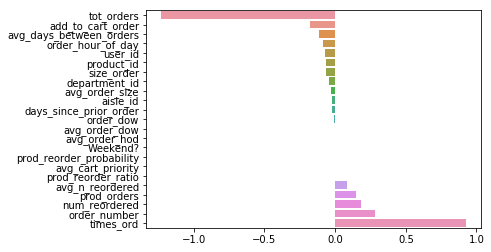

In [131]:
lr = LogisticRegression()
lr.fit(X_train.values, y_train.values)

coeffs = (lr.coef_.ravel()*featuresTrain.drop(dropped,1).std()).sort_values()

sns.barplot(coeffs.values, coeffs.index)

In [132]:
def computeF1(predictions_proba, y_true, thres):
    y_pred = (predictions_proba > thres).astype(int)
    
    return f1_score(y_pred, y_true)

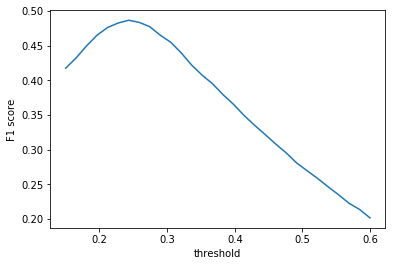

In [133]:
def plot_fl(model, feat):    
    thres = np.linspace(0.15,0.6,30)

    # The second column contains probabiity of positive
    proba_holdout = model.predict_proba(X_holdout[feat].values)[:,1]

    y = [computeF1(proba_holdout, y_holdout, t) for t in thres]
    plt.plot(thres, y)
    plt.ylabel("F1 score")
    plt.xlabel("threshold")
    
plot_fl(lr, X_holdout.columns)
#according to the result, when the threshold = 0.24 we can get the best f1 score 0.5

In [134]:
proba_holdout = lr.predict_proba(X_holdout[X_holdout.columns].values)[:,1]
computeF1(proba_holdout, y_holdout.values, 0.24)

0.4867464489430713

In [135]:
y_pred_lr = proba_holdout > 0.24

auclr =accuracy_score(y_holdout.values,y_pred_lr)
print(accuracy_score(y_holdout.values,y_pred_lr))
# score is the same as the probabilities
y_score_lr = proba_holdout

0.7474443114431557


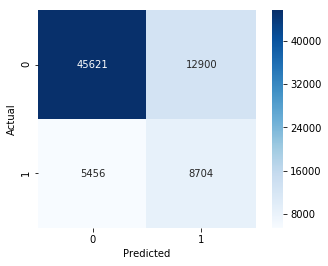

In [136]:
from sklearn.metrics import confusion_matrix

def cnf_mtx(probs, threshold):
    labels = [0, 1]
    y_true = y_holdout.values
    y_pred = probs > threshold
    y_pred = y_pred.astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred, labels)
    sns.heatmap(cnf_matrix, annot=True, xticklabels = labels, yticklabels = labels, cmap = 'Blues', fmt='g', square = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
cnf_mtx(proba_holdout, 0.24)

In [137]:
print("\tPrecision: %1.3f" % precision_score(y_holdout, y_pred_lr))
print("\tRecall: %1.3f" % recall_score(y_holdout, y_pred_lr))
print("\tF1: %1.3f\n" % f1_score(y_holdout, y_pred_lr))

	Precision: 0.403
	Recall: 0.615
	F1: 0.487



In [138]:
X_train_f = X_train[['avg_cart_priority','avg_n_reordered','avg_order_size','num_reordered','order_number','prod_reorder_probability','prod_reorder_ratio','size_order','tot_orders','times_ord']]
X_holdout_f = X_holdout[['avg_cart_priority','avg_n_reordered','avg_order_size','num_reordered','order_number','prod_reorder_probability','prod_reorder_ratio','size_order','tot_orders','times_ord']]

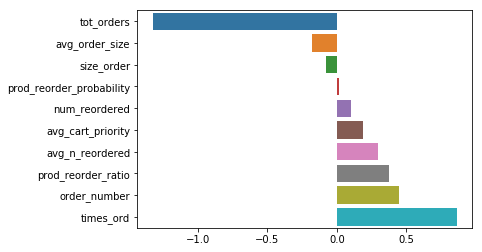

In [139]:
featuresTrain_f = featuresTrain[['avg_cart_priority','avg_n_reordered','avg_order_size','num_reordered','order_number','prod_reorder_probability','prod_reorder_ratio','size_order','tot_orders','times_ord']]

lr_f = LogisticRegression()
lr_f.fit(X_train_f.values, y_train.values)

coeffs = (lr_f.coef_.ravel()*featuresTrain_f.std()).sort_values()

sns.barplot(coeffs.values, coeffs.index)

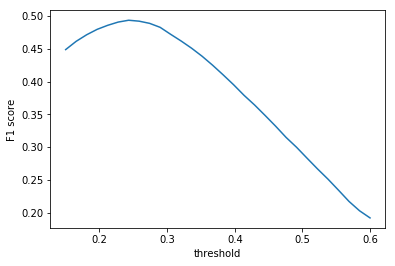

In [140]:
plot_fl(lr_f, X_holdout_f.columns)

In [142]:
proba_holdout_f = lr_f.predict_proba(X_holdout_f[X_holdout_f.columns].values)[:,1]
computeF1(proba_holdout_f, y_holdout.values, 0.24)


0.49278401721901827

###  f1 score slightly increased from 0.50 to 0.5237 after feature selection when the threshold = 0.25 


In [143]:
y_pred_lr_f = proba_holdout_f > 0.24

auclr_f =accuracy_score(y_holdout.values,y_pred_lr_f)
print(accuracy_score(y_holdout.values,y_pred_lr_f))
# score is the same as the probabilities
y_score_lr_f = proba_holdout_f

0.7471003425929748


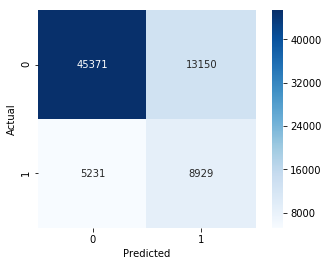

In [144]:
cnf_mtx(proba_holdout_f, 0.24)


In [145]:
print("\tPrecision: %1.3f" % precision_score(y_holdout, y_pred_lr_f))
print("\tRecall: %1.3f" % recall_score(y_holdout, y_pred_lr_f))
print("\tF1: %1.3f\n" % f1_score(y_holdout, y_pred_lr_f))

	Precision: 0.404
	Recall: 0.631
	F1: 0.493



# XGBoost Model and Model Tuning

In [146]:
xgb_model = xgb.XGBClassifier(max_depth=6, n_estimators=2000, learning_rate=0.05, nthread=-1)

eval_set = [(X_holdout, y_holdout)]

xgb_model.fit(X_train, y_train, early_stopping_rounds=50, 
        eval_metric=["auc"], eval_set=eval_set)

[0]	validation_0-auc:0.764411
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.763959
[2]	validation_0-auc:0.768115
[3]	validation_0-auc:0.76935
[4]	validation_0-auc:0.770955
[5]	validation_0-auc:0.773051
[6]	validation_0-auc:0.773556
[7]	validation_0-auc:0.773444
[8]	validation_0-auc:0.775875
[9]	validation_0-auc:0.77681
[10]	validation_0-auc:0.777392
[11]	validation_0-auc:0.77777
[12]	validation_0-auc:0.779075
[13]	validation_0-auc:0.781547
[14]	validation_0-auc:0.781747
[15]	validation_0-auc:0.781922
[16]	validation_0-auc:0.782935
[17]	validation_0-auc:0.7831
[18]	validation_0-auc:0.783298
[19]	validation_0-auc:0.784613
[20]	validation_0-auc:0.784319
[21]	validation_0-auc:0.784416
[22]	validation_0-auc:0.784559
[23]	validation_0-auc:0.784552
[24]	validation_0-auc:0.784815
[25]	validation_0-auc:0.784963
[26]	validation_0-auc:0.785346
[27]	validation_0-auc:0.785281
[28]	validation_0-auc:0.785981
[29]	validation_0-auc:0.785902
[30]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

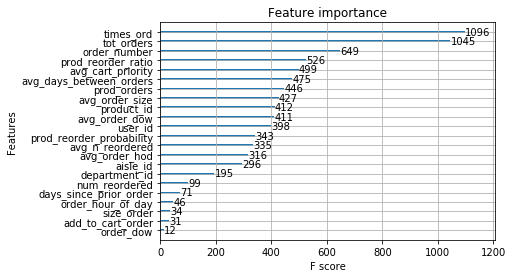

In [148]:
xgb.plot_importance(xgb_model, max_num_features=23);

In [149]:
from sklearn import preprocessing
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

# predict output with the test set
y_pred_XGB = xgb_model.predict(X_holdout)
# calculate xgboost classifier probabilities
y_prob_XGB = xgb_model.predict_proba(X_holdout)[:, 1]
aucxgb = accuracy_score(y_holdout,y_pred_XGB)
print("AUC Score : %f" % roc_auc_score(y_holdout, y_prob_XGB))
print("Accuracy : %.4g" % accuracy_score(y_holdout, y_pred_XGB))
# score is the same as the probabilities
y_score_XGB = y_prob_XGB

AUC Score : 0.791327
Accuracy : 0.8138


## Random Forest Model and Model Tuning

In [152]:
from sklearn.ensemble import RandomForestClassifier
# random forest classifier object instantiation with default setting, i.e. max_depth is not set to anything
# the default setting overfit each tree to the training set, no limit set for max_depth
rnd_clf = RandomForestClassifier(n_estimators=2000, n_jobs=1, max_depth = 6, random_state=0)
# fit the data using the training set
rnd_clf.fit(X_train, y_train)
# calculate random forest classifier probabilities
y_prob_rf = rnd_clf.predict_proba(X_holdout)
# predict output with the test set
y_pred_rf = rnd_clf.predict(X_holdout)
# determine accuracy score for the random forest classifier
aucrf = accuracy_score(y_holdout,y_pred_rf)
print(accuracy_score(y_holdout,y_pred_rf))
# score is the same as the probabilities
y_score_rf = y_prob_rf[:,1]

0.8148759648326248


In [153]:
print("\tPrecision: %1.3f" % precision_score(y_holdout, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_holdout, y_pred_rf))
print("\tF1: %1.3f\n" % f1_score(y_holdout, y_pred_rf))

	Precision: 0.799
	Recall: 0.066
	F1: 0.123



In [ ]:
f1_rf = f1_score(y_holdout, y_pred_rf)
importances = rnd_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rnd_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X_train.shape[1] -6):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       yerr=std[indices], align="center")
plt.yticks(range(X_train.shape[1]-6), X_train.columns[indices])
plt.ylim([-1, X_train.shape[1]-7])
plt.show()

In [ ]:
#RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth = 1, random_state=42)
from sklearn.model_selection import GridSearchCV

param_dict_rf = {'max_depth':[1,2,4,6,8], 'n_estimators':[500,1000,1500, 2000, 2500]}
 
rgs_rf = GridSearchCV(rnd_clf, param_dict_rf)
 
rgs_rf.fit(X_train, y_train)
 
print(rgs_rf.best_score_) 
print(rgs_rf.best_params_)

In [ ]:
# calculate false postive, true postive rates and therehold  of the Xgboost model for ROC
fpr_XGB,tpr_XGB, threshold_XGB = roc_curve(y_holdout, y_score_XGB)

# calculate false postive, true postive rates and therehold of Logistic Regression model for ROC 
#fpr_lr,tpr_lr, threshold_lr = roc_curve(y_holdout, y_score_lr_f)

# calculate false postive, true postive rates and therehold of Random Forest model for ROC
fpr_rf,tpr_rf, threshold_rf = roc_curve(y_holdout, y_score_rf)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(8, 8))

#plt.plot(fpr_lr,tpr_lr,label=' "Logsitic Regression:",auc  = %0.4f' % auclr_f)
plt.plot(fpr_rf,tpr_rf,label='Random Forest:auc  = {0:0.3f} , f1-score = {1:0.3f}'
             ''.format(aucrf, f1_rf) )
plt.plot(fpr_XGB,tpr_XGB,label='XGBoost:auc  = {0:0.3f} , f1-score = {1:0.3f}'
             ''.format(aucxgb, f1_xgb) )

# compare bagging method with standard decision tree classifier
# ROC curve plotting

# ROC curve plotting
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## since we get the best accurcy on the XGBoost model, we are going to take a look at the predicted data to see what types of products are likely to be reordered next time

In [ ]:
predictoutcome = X_holdout.copy()
predictoutcome['predict_prob'] = xgb_model.predict_proba(X_holdout)[:, 1]
predictoutcome['prediction'] = y_pred_XGB
predict_reorder = predictoutcome[predictoutcome['prediction'] == 1]
test = list (predict_reorder['product_id'])
name = []
for i in range(0, len(test)): 
    name.append(list(products[products['product_id'] == test[i] ]['product_name'])[0])
predict_reorder['product_name'] = pd.Series(name).values

In [ ]:
predict_reorder.head()

In [ ]:
df = predict_reorder[['predict_prob','add_to_cart_order','days_since_prior_order']]
df.head()
#histogram
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 3))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.distplot(v, ax=axs[index], kde=0, norm_hist=0)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
grouped1=predict_reorder['prediction'].groupby(predict_reorder['product_name']).count()
grouped1 = grouped1.sort_values(ascending= False)
grouped1= pd.DataFrame(grouped1).reset_index()
grouped1.columns = ['product_name', 'Frequency']
grouped1.head(25)